# Goal
* some initial data exploration and creating some util functions

In [1]:
INPUT_FILE = '../data/raw/who_suicide_statistics.csv'
POPULATION_FILE = '../data/raw/total_pop_1960_2018.csv'
META_DATA = '../data/raw/meta_data.csv'

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling
from itertools import product
import seaborn as sns

%matplotlib inline

In [ ]:
%load_ext autoreload
%autoreload 2

## read in data

In [3]:
df = pd.read_csv(INPUT_FILE)
df_population = pd.read_csv(POPULATION_FILE, skiprows=4)

In [4]:
df.head(20)

,country,year,sex,age,suicides_no,population
0,Albania,1985,female,15-24 years,NaN,277900.0
1,Albania,1985,female,25-34 years,NaN,246800.0
2,Albania,1985,female,35-54 years,NaN,267500.0
3,Albania,1985,female,5-14 years,NaN,298300.0
4,Albania,1985,female,55-74 years,NaN,138700.0
5,Albania,1985,female,75+ years,NaN,34200.0
6,Albania,1985,male,15-24 years,NaN,301400.0
7,Albania,1985,male,25-34 years,NaN,264200.0
8,Albania,1985,male,35-54 years,NaN,296700.0
9,Albania,1985,male,5-14 years,NaN,325800.0


## Some useful functions

In [5]:
#df.profile_report()

## Interpreting the report

From the report we see that:
* We have 141 different countries in our dataset
* If a country is represented in a given year, we have have 12 lines of data for it (6 different age groups for 2 genders)
* the 'population' column (giving the population size of the country) has quite a few missing values. We can fill in these missing values by e.g. setting the population size in year x to be the mean of the population sizes in year x-1 and x+1 (if they were not missing). 

## Getting a better idea of the data

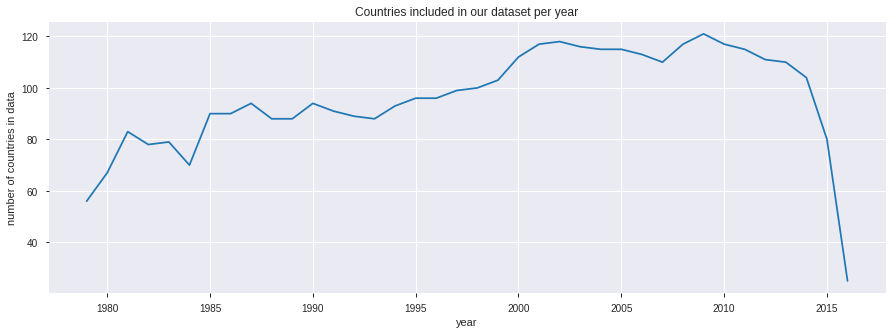

In [5]:
# the number of countries in our dataset by year
fig = plt.figure(figsize=(15,5))
plt.ylabel('number of countries in data')
plt.title('Countries included in our dataset per year')
df.groupby('year')['country'].nunique().plot();

In [6]:
# example of data from a single country in a single year
df.loc[(df['country'] == 'France') & (df['year'] == 1990)]

,country,year,sex,age,suicides_no,population
14628,France,1990,female,15-24 years,184.0,4175200.0
14629,France,1990,female,25-34 years,392.0,4308400.0
14630,France,1990,female,35-54 years,981.0,7178300.0
14631,France,1990,female,5-14 years,5.0,3535500.0
14632,France,1990,female,55-74 years,1002.0,5482800.0
14633,France,1990,female,75+ years,661.0,2583600.0
14634,France,1990,male,15-24 years,607.0,4318400.0
14635,France,1990,male,25-34 years,1314.0,4289900.0
14636,France,1990,male,35-54 years,2816.0,7267500.0
14637,France,1990,male,5-14 years,14.0,3705600.0


## Look at population distribution in different age groups

In [7]:
def add_age_group_fractions(data_frame):
    assert 'year' in data_frame, 'year column must be in dataframe'    
    assert 'country' in data_frame, 'country column must be in dataframe'    
    
    # get rid of all rows with nan values in the population column
    data_frame = data_frame.dropna(subset=['population'], how='any', axis=0)
    assert len(data_frame) % 12 == 0, f'length of data frame must be multiple of 12, not {len(data_frame)}'
    
    # add total population size column
    total_pop = data_frame.groupby(['country', 'year'])['population'].sum().reset_index()\
    .rename(columns={'population': 'total_population'})
    assert min(total_pop['total_population']) > 0, 'need valid total population count'
    df = pd.merge(data_frame, total_pop, how='left', on=['country', 'year'])
    
    # add column for relative pop size of each age group
    df['fraction_pop'] = df['population'] / df['total_population']
    assert ((df['fraction_pop'] >= 0) & df['fraction_pop'] <= 1).sum() == len(df)
    
    return df  


def get_age_group_stats(data_frame):
    assert 'fraction_pop' in data_frame, 'dataframe needs to have column fraction_pop'
    assert data_frame['fraction_pop'].isna().sum() == 0, 'there are nans in dataframe..'
    
    grouped = data_frame.groupby(['age', 'sex'])['fraction_pop'].mean().reset_index()
    total_fraction = grouped['fraction_pop'].sum()
    assert total_fraction <= 1.01 and total_fraction >= 0.99  # check whether overall fraction roughly 1
    
    # normalize to exactly 1.0 overall fraction
    grouped['fraction_pop'] = grouped['fraction_pop'] / grouped['fraction_pop'].sum()
    
    return grouped


def clean_population_stats(data_frame):
    df_pop = data_frame.drop(['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 63'], axis=1)
    df_pop = df_pop.rename(columns={'Country Name': 'country'})
    df_pop = df_pop.melt(id_vars=["country"], var_name="year", value_name='total_population')
    
    df_pop['year'] = df_pop['year'].astype('float')
    
    return df_pop
    

def fill_in_missing_populations(data_frame, df_population, df_age_statistics):
    
    added_age_stats = pd.merge(data_frame, df_age_statistics, how='left', on=['sex', 'age'])
    added_total_pop = pd.merge(added_age_stats, df_population, how='left', on=['country', 'year'])
    
    # now replace any missing values in population with the product of total population and fraction in age group
    mask = added_total_pop['population'].isnull()
    
    added_total_pop.loc[mask, 'population'] = added_total_pop['fraction_pop'][mask] * added_total_pop['total_population'][mask]
    # added_total_pop['population'][mask] = added_total_pop['fraction_pop'][mask] * added_total_pop['total_population'][mask]
    
    # drop total population column and fraction_pop columns
    added_total_pop.drop(columns=['fraction_pop', 'total_population'], inplace=True)
    
    return added_total_pop

In [8]:
age_stats = get_age_group_stats(add_age_group_fractions(df))

In [9]:
age_stats

,age,sex,fraction_pop
0,15-24 years,female,0.088361
1,15-24 years,male,0.091571
2,25-34 years,female,0.083171
3,25-34 years,male,0.085668
4,35-54 years,female,0.134128
5,35-54 years,male,0.133725
6,5-14 years,female,0.089561
7,5-14 years,male,0.093406
8,55-74 years,female,0.084270
9,55-74 years,male,0.072173


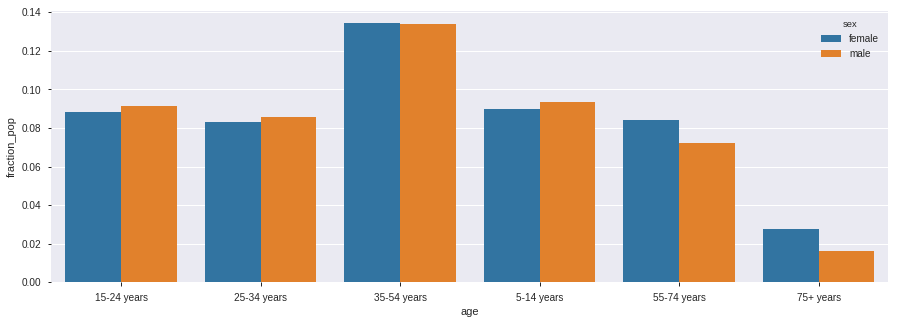

In [10]:
# unsurprisingly, we see that males and females make up about the same fraction, but the females group is larger
# in the two oldest age groups.
fig = plt.figure(figsize=(15, 5))
sns.barplot(x="age", y="fraction_pop", hue="sex", data=age_stats)

## Clean up population statistics file

In [11]:
df_pop = clean_population_stats(df_population)

In [12]:
df_pop.head()

,country,year,total_population
0,Aruba,1960.0,54211.0
1,Afghanistan,1960.0,8996973.0
2,Angola,1960.0,5454933.0
3,Albania,1960.0,1608800.0
4,Andorra,1960.0,13411.0


## Add population stats for missing values

In [13]:
enriched_df = fill_in_missing_populations(df, df_pop, age_stats)

In [14]:
enriched_df.head(20)

,country,year,sex,age,suicides_no,population
0,Albania,1985,female,15-24 years,NaN,277900.0
1,Albania,1985,female,25-34 years,NaN,246800.0
2,Albania,1985,female,35-54 years,NaN,267500.0
3,Albania,1985,female,5-14 years,NaN,298300.0
4,Albania,1985,female,55-74 years,NaN,138700.0
5,Albania,1985,female,75+ years,NaN,34200.0
6,Albania,1985,male,15-24 years,NaN,301400.0
7,Albania,1985,male,25-34 years,NaN,264200.0
8,Albania,1985,male,35-54 years,NaN,296700.0
9,Albania,1985,male,5-14 years,NaN,325800.0


## Look at report again

We managed to reduce the lines with nans in the total population columns. Now we can start to do some analyses on this new data

In [24]:
enriched_df.profile_report()

In [33]:
null_pop = df.loc[df['population'].isnull()]

In [34]:
null_pop2 = pd.merge(df, age_stats, how='left', on=['sex', 'age'])

In [35]:
null_pop2.head()

,country,year,sex,age,suicides_no,population,fraction_pop
0,Albania,1985,female,15-24 years,NaN,277900.0,0.088361
1,Albania,1985,female,25-34 years,NaN,246800.0,0.083171
2,Albania,1985,female,35-54 years,NaN,267500.0,0.134128
3,Albania,1985,female,5-14 years,NaN,298300.0,0.089561
4,Albania,1985,female,55-74 years,NaN,138700.0,0.084270


In [36]:
null_pop3 = pd.merge(null_pop2, df_pop, how='left', on=['country', 'year'])

In [37]:
null_pop3.head(20)

,country,year,sex,age,suicides_no,population,fraction_pop,total_population
0,Albania,1985,female,15-24 years,NaN,277900.0,0.088361,2964762.0
1,Albania,1985,female,25-34 years,NaN,246800.0,0.083171,2964762.0
2,Albania,1985,female,35-54 years,NaN,267500.0,0.134128,2964762.0
3,Albania,1985,female,5-14 years,NaN,298300.0,0.089561,2964762.0
4,Albania,1985,female,55-74 years,NaN,138700.0,0.084270,2964762.0
5,Albania,1985,female,75+ years,NaN,34200.0,0.027732,2964762.0
6,Albania,1985,male,15-24 years,NaN,301400.0,0.091571,2964762.0
7,Albania,1985,male,25-34 years,NaN,264200.0,0.085668,2964762.0
8,Albania,1985,male,35-54 years,NaN,296700.0,0.133725,2964762.0
9,Albania,1985,male,5-14 years,NaN,325800.0,0.093406,2964762.0


In [38]:
mask = null_pop3['population'].isnull()

In [43]:
null_pop3[mask]['population'].isnull().sum() / mask.sum()

1.0

In [44]:
null_pop3.loc[mask, 'population'] = null_pop3['fraction_pop'][mask] * null_pop3['total_population'][mask]

In [45]:
null_pop3[mask]['population'].isnull().sum() / mask.sum()

0.25934065934065936